## Extension Data Exploration and Health Indicators Forecasts

Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.varmax import VARMAX # used to forecast health indicators for 2025 - 2050 (more on this below)

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

Smoke estimate using ARIMA from [part_1_AQI.ipynb](../part_1/part_1_AQI.ipynb)

In [2]:
df_smoke_estimate = pd.read_csv("/Users/dianechiang/Desktop/data_512/data_512_project/project/part_1/data_intermediate/Smoke Estimate using ARIMA.csv")
df_smoke_estimate.head()

,fire_year,fitted_smoke_estimate
0,1964,0.000000
1,1965,0.072602
2,1966,0.006527
3,1967,0.022991
4,1968,0.164726


## Compressed Mortality, 1968 - 1978, 1979 - 1998, 1999 - 2016
* The Compressed Mortality File (CMF) is a comprehensive national database from the Centers for Disease Control and Prevention, providing county-level data on mortality and population from 1968 to 2016.
* We are interested in potential wildfire-related respiratory conditions, such as "asthma", "chronic obstructive pulmonary disease, unspecified", and "chronic obstructive pulmonary disease with acute lower respiratory infection".

In [3]:
df_compressed_mortality = pd.DataFrame()
comp_mortality = [
    "Compressed Mortality, 1968-1978.txt",
    "Compressed Mortality, 1979-1998.txt",
    "Compressed Mortality, 1999-2016.txt"
]

for file in comp_mortality:
    df = pd.read_csv("health_related_data/compressed_mortality/" + file, delimiter="\t", encoding="latin-1")
    df = df[df["County"] == "Ector County, TX"]
    if df_compressed_mortality.empty:
        df_compressed_mortality = df
    else:
        df_compressed_mortality = pd.concat([df_compressed_mortality, df], axis=0)

# remove unnecessary columns
df_compressed_mortality = df_compressed_mortality.drop(["Notes", "State Code", "County Code", 
                                                        "Year Code", "Cause of death Code"], axis=1).reset_index(drop=True)

# keep the relevant respiratory conditions
conditions_of_interst = ["Asthma", "Chronic obstructive pulmonary disease, unspecified",
                         "Chronic obstructive pulmonary disease with acute lower respiratory infection"]
df_compressed_mortality = df_compressed_mortality[df_compressed_mortality["Cause of death"].isin(conditions_of_interst)]
df_compressed_mortality_cases = df_compressed_mortality[["Year", "Cause of death", "Deaths"]]

# cast year and deaths as type integer
df_compressed_mortality_cases["Year"] = df_compressed_mortality_cases["Year"].astype(int)
df_compressed_mortality_cases["Deaths"] = df_compressed_mortality_cases["Deaths"].astype(int)
df_compressed_mortality_cases.head()

,Year,Cause of death,Deaths
9,1968,Asthma,2
62,1972,Asthma,4
110,1976,Asthma,1
119,1977,Asthma,1
308,1999,"Chronic obstructive pulmonary disease, unspeci...",65


Visualizing sum of all relevant respiratory related mortality cases

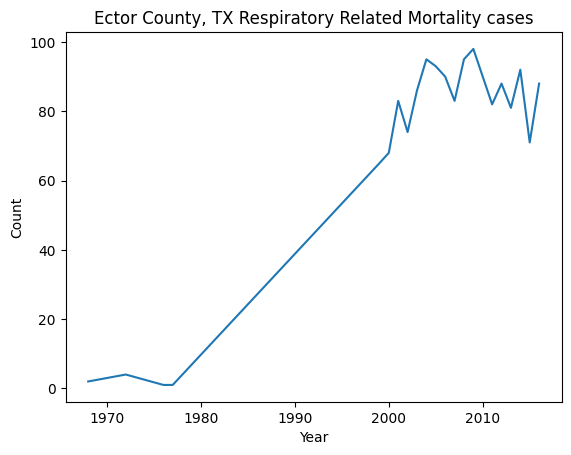

In [4]:
df_compressed_mortality_cases_by_year = df_compressed_mortality_cases.groupby(["Year"])["Deaths"].agg("sum").reset_index()
plt.plot(df_compressed_mortality_cases_by_year["Year"], df_compressed_mortality_cases_by_year["Deaths"])
plt.title("Ector County, TX Respiratory Related Mortality cases")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

## United States and Puerto Rico Cancer Statistics, 1999 - 2021
* The United States Cancer Statistics (USCS) provides the official federal statistics on cancer incidence and mortality across the 50 states and the District of Columbia, sourced from registries that meet high-quality data standards.
* We're interested in cancer sites such as "respiratory system", "lung and bronchus", and "trachea, mediastinum and other respiratory organs"

In [5]:
# US cancer incidence
df_cancer = pd.read_csv("health_related_data/us_cancer_stats/United States and Puerto Rico Cancer Statistics, 1999-2021 Incidence.txt",
                        delimiter="\t",
                        encoding="latin-1")
cancer_of_interest = ['Respiratory System', 'Lung and Bronchus', 'Trachea, Mediastinum and Other Respiratory Organs']
df_cancer = df_cancer[df_cancer["Cancer Sites"].isin(cancer_of_interest)]
df_cancer = df_cancer[["Year", "Cancer Sites", "Count", "Age-Adjusted Rate", "Crude Rate"]].reset_index(drop=True)
df_cancer["Year"] = df_cancer["Year"].astype(int)
df_cancer.head()

,Year,Cancer Sites,Count,Age-Adjusted Rate,Crude Rate
0,1999,Respiratory System,13015.0,77.3,63.3
1,1999,Lung and Bronchus,11969.0,71.3,58.2
2,1999,"Trachea, Mediastinum and Other Respiratory Organs",49.0,0.3,0.2
3,2000,Respiratory System,12958.0,75.4,61.9
4,2000,Lung and Bronchus,11980.0,69.9,57.2


In [6]:
# US cancer deaths
df_cancer_mort = pd.read_csv("health_related_data/us_cancer_stats/United States and Puerto Rico Cancer Statistics, 1999-2021 Mortality.txt",
                             delimiter="\t",
                             encoding="latin-1")
df_cancer_mort = df_cancer_mort[df_cancer_mort["Cancer Sites"].isin(cancer_of_interest)]
df_cancer_mort = df_cancer_mort[["Year", "Cancer Sites", "Deaths"]].reset_index(drop=True)
df_cancer_mort["Year"] = df_cancer_mort["Year"].astype(int)
df_cancer_mort.head()

,Year,Cancer Sites,Deaths
0,1999,Respiratory System,9471.0
1,1999,Lung and Bronchus,9186.0
2,1999,"Trachea, Mediastinum and Other Respiratory Organs",17.0
3,2000,Respiratory System,9796.0
4,2000,Lung and Bronchus,9470.0


## CDS PLACES data
* This dataset contains model-based, county-level estimates provided by the Centers for Disease Control and Prevention, Division of Population Health, Epidemiology and Surveillance Branch.
* We're interested in conditions related to asthma and chronic obstructive pulmonary disease. Columns include "CASTHMA_CrudePrev", "CASTHMA_AdjPrev", "COPD_CrudePrev", and "COPD_AdjPrev".

In [7]:
places_data = {
    2020: "places/PLACES__County_Data__GIS_Friendly_Format___2020_release_20241102.csv",
    2021: "places/PLACES__County_Data__GIS_Friendly_Format___2021_release_20241102.csv",
    2022: "places/PLACES__County_Data__GIS_Friendly_Format___2022_release_20241102.csv",
    2023: "places/PLACES__County_Data__GIS_Friendly_Format___2023_release_20241102.csv",
    2024: "places/PLACES__County_Data__GIS_Friendly_Format___2024_release_20241102.csv"
}

relevant_cols = ["CountyName", "TotalPopulation"]
df_places = pd.DataFrame()

for year, file in places_data.items():
    df = pd.read_csv("health_related_data/" + file)
    relevant_cols += df.columns[df.columns.str.startswith('CASTHMA') | 
                            df.columns.str.startswith('COPD')].tolist()
    df = df[df.columns[df.columns.isin(relevant_cols)]]
    df = df[df["CountyName"] == "Ector"].reset_index(drop=True)
    df["Year"] = year
    if df_places.empty:
        df_places = df
    else:
        df_places = pd.concat([df_places, df], axis=0)
df_places = df_places.reset_index(drop=True)
df_places = df_places[["Year", "CASTHMA_CrudePrev", "CASTHMA_AdjPrev", "COPD_CrudePrev", "COPD_AdjPrev"]]
df_places

,Year,CASTHMA_CrudePrev,CASTHMA_AdjPrev,COPD_CrudePrev,COPD_AdjPrev
0,2020,8.6,8.6,5.9,6.3
1,2021,8.0,8.0,5.0,5.6
2,2022,9.0,8.9,5.6,6.0
3,2023,9.4,9.3,6.2,6.5
4,2024,9.6,9.5,6.4,6.6


Visualzing CASTHMA_CrudePrev over 2020 - 2024

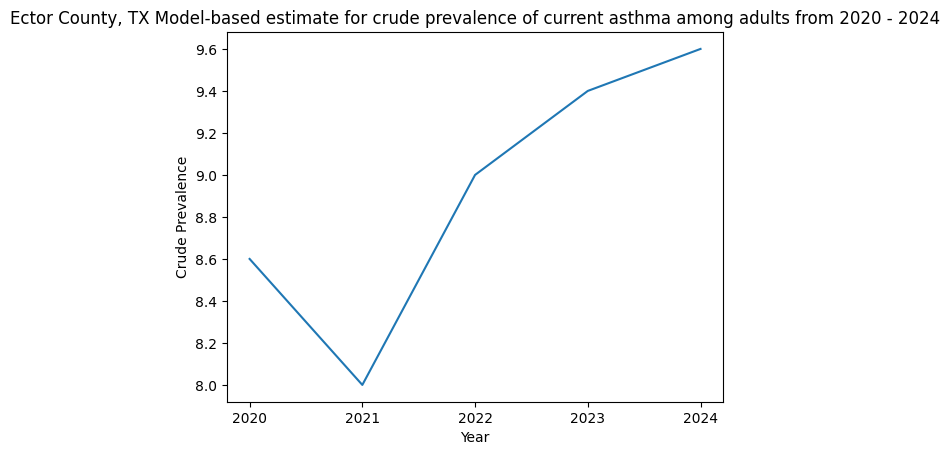

In [8]:
plt.plot(df_places["Year"], df_places["CASTHMA_CrudePrev"])
plt.title("Ector County, TX Model-based estimate for crude prevalence of current asthma among adults from 2020 - 2024")
plt.xlabel("Year")
plt.ylabel("Crude Prevalence")
plt.xticks(df_places["Year"].astype(int))
plt.show()

Visualizing COPD_CrudePrev from 2020 - 2024

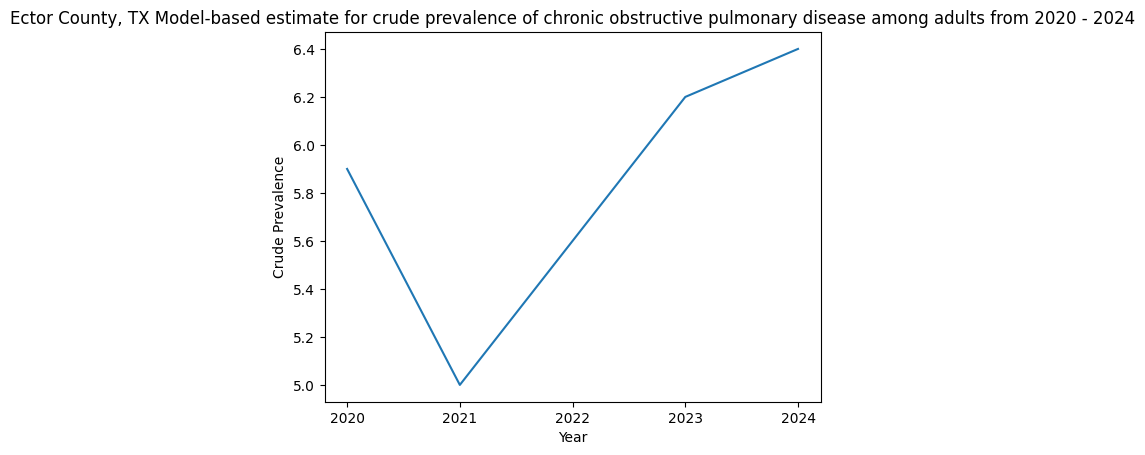

In [9]:
plt.plot(df_places["Year"], df_places["COPD_CrudePrev"])
plt.title("Ector County, TX Model-based estimate for crude prevalence of chronic obstructive pulmonary disease among adults from 2020 - 2024")
plt.xlabel("Year")
plt.ylabel("Crude Prevalence")
plt.xticks(df_places["Year"].astype(int))
plt.show()

## Texas Birth Defects Registry (TBDR) Annual Report, 1999 - 2020
* The Texas Birth Defects Registry (TBDR) Annual Report provides records of birth defects across various body systems in Texas, with data including year, cases, prevalence rate, and confidence interval.
* Since individual birth defects that may be influenced by population and/or wildfire smoke, we sum up all the birth defects to observe the general trends.

In [11]:
df_birth_defect = pd.read_excel("health_related_data/birth_defects/1999-2020-TBDR-2-PrevByYear.xlsx", skiprows=3)  # first 3 rows are headers and metadata
df_birth_defect = df_birth_defect.dropna(subset=["Year"])
df_birth_defect["Year"] = df_birth_defect["Year"].astype(int)
df_birth_defect_cases = df_birth_defect[["Birth Defect (Body System)", "Year", "Cases‒ (count)."]]
df_birth_defect_cases = df_birth_defect_cases.rename(columns={
    "Birth Defect (Body System)": "birth_defect",
    "Year": "year",
    "Cases‒ (count).": "cases"
    }
)
df_total_birth_def_cnt = df_birth_defect_cases.groupby("year")['cases'].agg('sum').reset_index()
df_total_birth_def_cnt.head()

,year,cases
0,1999,22905.0
1,2000,24200.0
2,2001,24427.0
3,2002,25405.0
4,2003,26672.0


Visualizing total birth defect cases in Texas

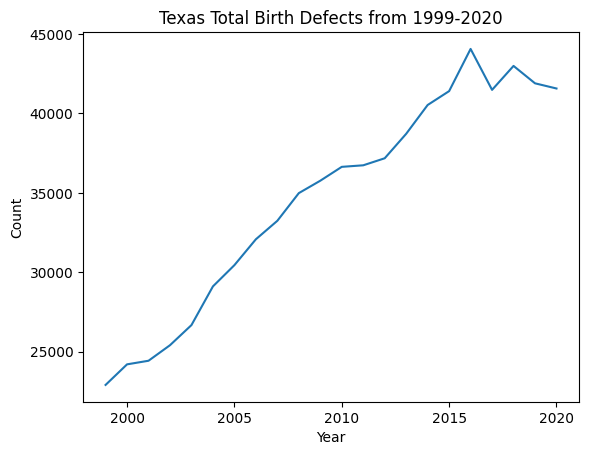

In [ ]:
plt.plot(df_total_birth_def_cnt["year"], df_total_birth_def_cnt["cases"])
plt.title("Texas Total Birth Defects from 1999-2020")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

## All health-related datasets of interests

In [12]:
# pivot compressed mortality table to have each condition as a column
# NaN remains for missing data
df_compressed_mortality_cases_pivot = df_compressed_mortality_cases.pivot_table(index="Year", columns="Cause of death", values="Deaths").reset_index()
df_compressed_mortality_cases_pivot.columns.name = None
df_compressed_mortality_cases_pivot.head()

,Year,Asthma,Chronic obstructive pulmonary disease with acute lower respiratory infection,"Chronic obstructive pulmonary disease, unspecified"
0,1968,2.0,NaN,NaN
1,1972,4.0,NaN,NaN
2,1976,1.0,NaN,NaN
3,1977,1.0,NaN,NaN
4,1999,NaN,NaN,65.0


In [13]:
# pivot cancer incidence table to have each condition as a column
df_cancer_incidence_pivot = df_cancer.pivot_table(index="Year", columns="Cancer Sites", values=["Count", "Age-Adjusted Rate", "Crude Rate"]).reset_index()

# we look at incidence and mortality, so rename each column with _incidence to distinguish
df_cancer_incidence_pivot.columns = ['_'.join(col).strip() + "_incidence" for col in df_cancer_incidence_pivot.columns.values]
df_cancer_incidence_pivot = df_cancer_incidence_pivot.rename(columns={
    "Year__incidence": "Year"
})
df_cancer_incidence_pivot.head()

,Year,Age-Adjusted Rate_Lung and Bronchus_incidence,Age-Adjusted Rate_Respiratory System_incidence,"Age-Adjusted Rate_Trachea, Mediastinum and Other Respiratory Organs_incidence",Count_Lung and Bronchus_incidence,Count_Respiratory System_incidence,"Count_Trachea, Mediastinum and Other Respiratory Organs_incidence",Crude Rate_Lung and Bronchus_incidence,Crude Rate_Respiratory System_incidence,"Crude Rate_Trachea, Mediastinum and Other Respiratory Organs_incidence"
0,1999,71.3,77.3,0.3,11969.0,13015.0,49.0,58.2,63.3,0.2
1,2000,69.9,75.4,0.2,11980.0,12958.0,36.0,57.2,61.9,0.2
2,2001,70.8,76.4,0.2,12372.0,13374.0,35.0,58.0,62.7,0.2
3,2002,70.4,75.9,0.2,12576.0,13601.0,44.0,58.0,62.7,0.2
4,2003,70.5,75.9,0.2,12899.0,13933.0,49.0,58.5,63.2,0.2


In [14]:
# pivot cancer death table to have each condition as a column
df_cancer_death_pivot = df_cancer_mort.pivot_table(index="Year", columns="Cancer Sites", values="Deaths").reset_index()

# we look at incidence and mortality, so rename each column with _deaths to distinguish
df_cancer_death_pivot.columns = [col + "_deaths" for col in df_cancer_death_pivot.columns.values]
df_cancer_death_pivot = df_cancer_death_pivot.rename(columns={
    "Year_deaths": "Year"
})
df_cancer_death_pivot.head()

,Year,Lung and Bronchus_deaths,Respiratory System_deaths,"Trachea, Mediastinum and Other Respiratory Organs_deaths"
0,1999,9186.0,9471.0,17.0
1,2000,9470.0,9796.0,20.0
2,2001,9395.0,9678.0,NaN
3,2002,9797.0,10093.0,21.0
4,2003,9725.0,10029.0,16.0


In [15]:
# rename birth defect columns for clarity
df_total_birth_def_cnt = df_total_birth_def_cnt.rename(columns={
    "year": "Year",
    "cases": "total_birth_defect_count"
})
df_total_birth_def_cnt.head()

,Year,total_birth_defect_count
0,1999,22905.0
1,2000,24200.0
2,2001,24427.0
3,2002,25405.0
4,2003,26672.0


In [16]:
# merge all health-related data
data = [df_compressed_mortality_cases_pivot, df_cancer_incidence_pivot, df_cancer_death_pivot, df_places, df_total_birth_def_cnt]
df_total = pd.DataFrame()
for d in data:
    if df_total.empty:
        df_total = d
    else:
        df_total = df_total.merge(d, on="Year", how="outer")
df_total.head(5)

,Year,Asthma,Chronic obstructive pulmonary disease with acute lower respiratory infection,"Chronic obstructive pulmonary disease, unspecified",Age-Adjusted Rate_Lung and Bronchus_incidence,Age-Adjusted Rate_Respiratory System_incidence,"Age-Adjusted Rate_Trachea, Mediastinum and Other Respiratory Organs_incidence",Count_Lung and Bronchus_incidence,Count_Respiratory System_incidence,"Count_Trachea, Mediastinum and Other Respiratory Organs_incidence",...,Crude Rate_Respiratory System_incidence,"Crude Rate_Trachea, Mediastinum and Other Respiratory Organs_incidence",Lung and Bronchus_deaths,Respiratory System_deaths,"Trachea, Mediastinum and Other Respiratory Organs_deaths",CASTHMA_CrudePrev,CASTHMA_AdjPrev,COPD_CrudePrev,COPD_AdjPrev,total_birth_defect_count
0,1968,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1972,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1976,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1977,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1999,NaN,NaN,65.0,71.3,77.3,0.3,11969.0,13015.0,49.0,...,63.3,0.2,9186.0,9471.0,17.0,NaN,NaN,NaN,NaN,22905.0


## Wildfire Smoke Estimate using ARIMA in [part_1_AQI.ipynb](../part_1/part_1_AQI.ipynb)

In [17]:
df_smoke_estime_before_2025 = df_smoke_estimate[df_smoke_estimate["fire_year"] <= 2024]
df_smoke_estime_before_2025

,fire_year,fitted_smoke_estimate
0,1964,0.000000
1,1965,0.072602
2,1966,0.006527
3,1967,0.022991
4,1968,0.164726
...,...,...
56,2020,12.843718
57,2021,7.549189
58,2022,8.168520
59,2023,8.027841


### Limitations: Handling Missing Data by Filling NaN with Zero

One limitation in predicting health indicators for 2025–2050 is the need to fill all missing values (NaN) with zeros. While this approach makes the dataset complete and ready for modeling, it comes with some challenges:

- **Assumes No Impact for Missing Data**: Filling NaN values with zero assumes that missing data means there’s no effect, which might not be true. Missing values could reflect incomplete data collection, not a lack of health incidents, which could lead to underestimating actual trends.

- **Smooths Out Important Trends**: Replacing NaN with zeros can flatten variations in the data, potentially hiding spikes or declines in health indicators that are important for understanding true patterns. This might affect how well the forecasting model picks up on real trends.

- **May Affect Prediction Accuracy**: Since models like ARIMA rely on historical data to learn patterns, introducing zeros where data is missing might skew the relationships. This could lead to less accurate predictions, especially if missing data happens during key events like high wildfire activity.

- **Can Mislead Stakeholders**: Using zeros for missing values might make health impacts look smaller than they actually are, which could lead to underestimating the need for interventions or planning.

### How This Was Handled
Filling NaN with zeros was chosen for simplicity, but it’s important to interpret results carefully, keeping these limitations in mind. Future improvements could explore other ways to handle missing data, like interpolation or predictive imputation, to make the predictions more accurate and reliable.

In [18]:
# merge historical smoke estimate with health related data
merged_df = pd.merge(df_smoke_estime_before_2025, df_total, left_on="fire_year", right_on="Year", how="left").drop(columns=['Year'])

# fill NAs with 0s since there cannot be NaNs for VARMAX
merged_df_fill_na_with_0 = merged_df.fillna(0)
merged_df_fill_na_with_0.head(3)

,fire_year,fitted_smoke_estimate,Asthma,Chronic obstructive pulmonary disease with acute lower respiratory infection,"Chronic obstructive pulmonary disease, unspecified",Age-Adjusted Rate_Lung and Bronchus_incidence,Age-Adjusted Rate_Respiratory System_incidence,"Age-Adjusted Rate_Trachea, Mediastinum and Other Respiratory Organs_incidence",Count_Lung and Bronchus_incidence,Count_Respiratory System_incidence,...,Crude Rate_Respiratory System_incidence,"Crude Rate_Trachea, Mediastinum and Other Respiratory Organs_incidence",Lung and Bronchus_deaths,Respiratory System_deaths,"Trachea, Mediastinum and Other Respiratory Organs_deaths",CASTHMA_CrudePrev,CASTHMA_AdjPrev,COPD_CrudePrev,COPD_AdjPrev,total_birth_defect_count
0,1964,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1965,0.072602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1966,0.006527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# all columns
merged_df_fill_na_with_0.columns

Index(['fire_year', 'fitted_smoke_estimate', 'Asthma',
       'Chronic obstructive pulmonary disease with acute lower respiratory infection',
       'Chronic obstructive pulmonary disease, unspecified',
       'Age-Adjusted Rate_Lung and Bronchus_incidence',
       'Age-Adjusted Rate_Respiratory System_incidence',
       'Age-Adjusted Rate_Trachea, Mediastinum and Other Respiratory Organs_incidence',
       'Count_Lung and Bronchus_incidence',
       'Count_Respiratory System_incidence',
       'Count_Trachea, Mediastinum and Other Respiratory Organs_incidence',
       'Crude Rate_Lung and Bronchus_incidence',
       'Crude Rate_Respiratory System_incidence',
       'Crude Rate_Trachea, Mediastinum and Other Respiratory Organs_incidence',
       'Lung and Bronchus_deaths', 'Respiratory System_deaths',
       'Trachea, Mediastinum and Other Respiratory Organs_deaths',
       'CASTHMA_CrudePrev', 'CASTHMA_AdjPrev', 'COPD_CrudePrev',
       'COPD_AdjPrev', 'total_birth_defect_count'],
   

In [20]:
# rename each column for ease of reading
# the dataframe with NaN filled as 0s
merged_df_fill_na_with_0 = merged_df_fill_na_with_0.rename(columns={
    "Asthma": "Asthma Deaths",
    "Chronic obstructive pulmonary disease with acute lower respiratory infection": "COPD with Acute Lower Respiratory Infection Deaths",
    "Chronic obstructive pulmonary disease, unspecified": "COPD, unspecified Deaths",
    "Age-Adjusted Rate_Lung and Bronchus_incidence": "Lung and Bronchus Cancer Age-Adjusted Rate",
    "Age-Adjusted Rate_Respiratory System_incidence": "Respiratory System Cancer Age-Adjusted Rate",
    "Age-Adjusted Rate_Trachea, Mediastinum and Other Respiratory Organs_incidence": "Trachea, Mediastinum and Other Respiratory Organs Cancer Age-Adjusted Rate",
    "Count_Lung and Bronchus_incidence": "Lung and Bronchus Cancer Cases",
    "Count_Respiratory System_incidence": "Respiratory System Cacner Cases",
    "Count_Trachea, Mediastinum and Other Respiratory Organs_incidence": "Trachea, Mediastinum and Other Respiratory Organs Cancer Cases",
    "Crude Rate_Lung and Bronchus_incidence": "Lung and Bronchus Cancer Crude Rate",
    "Crude Rate_Respiratory System_incidence": "Respiratory System Cancer Crude Rate",
    "Crude Rate_Trachea, Mediastinum and Other Respiratory Organs_incidence": "Trachea, Mediastinum and Other Respiratory Organs Cancer Crude Rate",
    "Lung and Bronchus_deaths": "Lung and Bronchus Cancer Deaths",
    "Respiratory System_deaths": "Respiratory System Cancer Deaths",
    "Trachea, Mediastinum and Other Respiratory Organs_deaths": "Trachea, Mediastinum and Other Respiratory Organs Cancer Deaths",
    "CASTHMA_CrudePrev": "Asthma Crude Prevalence",
    "CASTHMA_AdjPrev": "Asthma Age-Adjusted Prevalence",
    "COPD_CrudePrev": "COPD Crude Prevalence",
    "COPD_AdjPrev": "COPD Age-Adjusted Prevalence",
    "total_birth_defect_count": "Total Birth Defects Cases"
})

In [21]:
# rename each column for ease of reading
# the dataframe with NaN kept as is
merged_df = merged_df.rename(columns={
    "Asthma": "Asthma Deaths",
    "Chronic obstructive pulmonary disease with acute lower respiratory infection": "COPD with Acute Lower Respiratory Infection Deaths",
    "Chronic obstructive pulmonary disease, unspecified": "COPD, unspecified Deaths",
    "Age-Adjusted Rate_Lung and Bronchus_incidence": "Lung and Bronchus Cancer Age-Adjusted Rate",
    "Age-Adjusted Rate_Respiratory System_incidence": "Respiratory System Cancer Age-Adjusted Rate",
    "Age-Adjusted Rate_Trachea, Mediastinum and Other Respiratory Organs_incidence": "Trachea, Mediastinum and Other Respiratory Organs Cancer Age-Adjusted Rate",
    "Count_Lung and Bronchus_incidence": "Lung and Bronchus Cancer Cases",
    "Count_Respiratory System_incidence": "Respiratory System Cacner Cases",
    "Count_Trachea, Mediastinum and Other Respiratory Organs_incidence": "Trachea, Mediastinum and Other Respiratory Organs Cancer Cases",
    "Crude Rate_Lung and Bronchus_incidence": "Lung and Bronchus Cancer Crude Rate",
    "Crude Rate_Respiratory System_incidence": "Respiratory System Cancer Crude Rate",
    "Crude Rate_Trachea, Mediastinum and Other Respiratory Organs_incidence": "Trachea, Mediastinum and Other Respiratory Organs Cancer Crude Rate",
    "Lung and Bronchus_deaths": "Lung and Bronchus Cancer Deaths",
    "Respiratory System_deaths": "Respiratory System Cancer Deaths",
    "Trachea, Mediastinum and Other Respiratory Organs_deaths": "Trachea, Mediastinum and Other Respiratory Organs Cancer Deaths",
    "CASTHMA_CrudePrev": "Asthma Crude Prevalence",
    "CASTHMA_AdjPrev": "Asthma Age-Adjusted Prevalence",
    "COPD_CrudePrev": "COPD Crude Prevalence",
    "COPD_AdjPrev": "COPD Age-Adjusted Prevalence",
    "total_birth_defect_count": "Total Birth Defects Cases"
})

Plot historical data of each health indicator

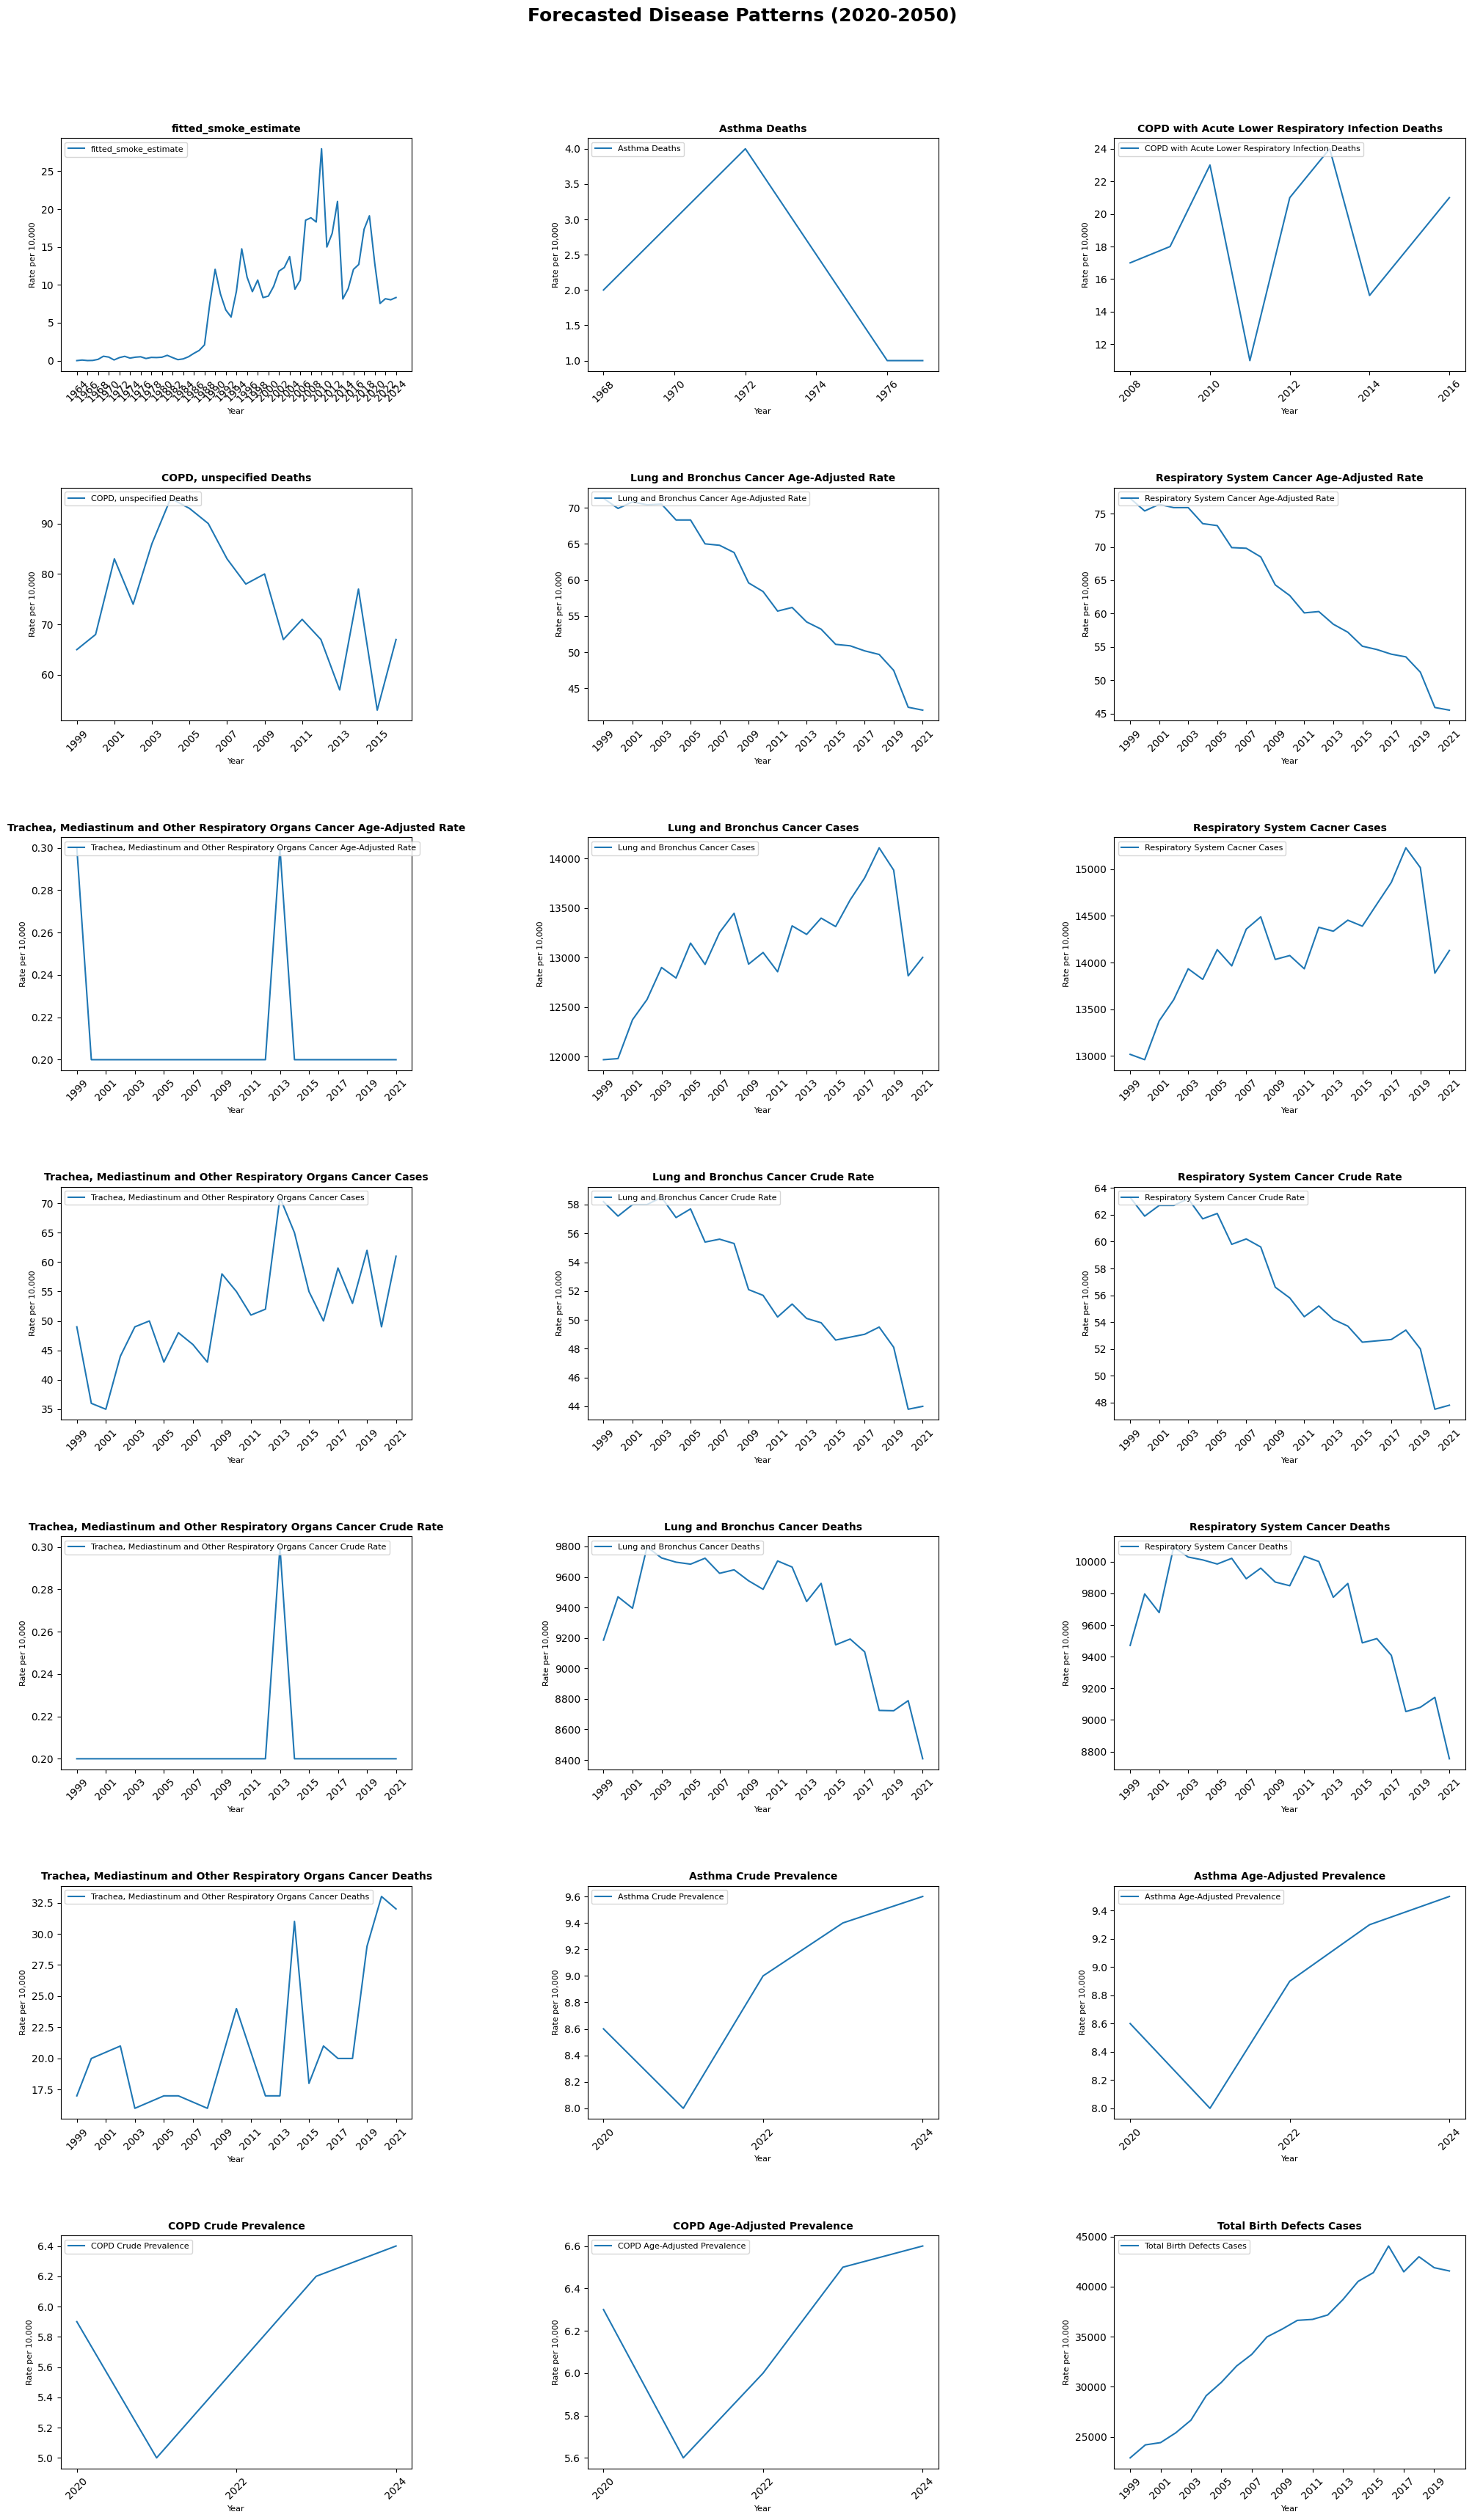

In [22]:
# year set as index
if 'fire_year' in merged_df.columns:
    merged_df['fire_year'] = pd.to_datetime(merged_df['fire_year'], format='%Y')
    merged_df.set_index('fire_year', inplace=True)


num_vars = len(merged_df.columns)
num_rows = (num_vars + 2) // 3

# subplots with larger spacing
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(20, num_rows * 5))
axes = axes.flatten()  # Flatten axes for easier iteration

# iterate through columns for individual plots
for i, column in enumerate(merged_df.columns):
    # drop NaN values only for the current column
	subset = merged_df[[column]].dropna()
	sns.lineplot(data=subset, x=subset.index.year, y=column, ax=axes[i], label=column)

	years = subset.index.year.unique() 
	ticks = np.arange(years.min(), years.max() + 1, 2)  # ticks every 3 years
	axes[i].set_xticks(ticks)
	axes[i].set_xticklabels(ticks.astype(int), rotation=45)
	axes[i].set_title(column.replace("Chronic obstructive pulmonary disease", "COPD"), fontsize=10, weight='bold')
	axes[i].set_xlabel('Year', fontsize=8)
	axes[i].set_ylabel('Rate per 10,000', fontsize=8)
	axes[i].legend(loc="upper left", fontsize=8)


for j in range(len(merged_df.columns), len(axes)):
    fig.delaxes(axes[j])

# add title and adjust layout
plt.suptitle("Forecasted Disease Patterns (2020-2050)", fontsize=18, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.5, wspace=0.5)

plt.show()

In [23]:
merged_df_fill_na_with_0.head()

,fire_year,fitted_smoke_estimate,Asthma Deaths,COPD with Acute Lower Respiratory Infection Deaths,"COPD, unspecified Deaths",Lung and Bronchus Cancer Age-Adjusted Rate,Respiratory System Cancer Age-Adjusted Rate,"Trachea, Mediastinum and Other Respiratory Organs Cancer Age-Adjusted Rate",Lung and Bronchus Cancer Cases,Respiratory System Cacner Cases,...,Respiratory System Cancer Crude Rate,"Trachea, Mediastinum and Other Respiratory Organs Cancer Crude Rate",Lung and Bronchus Cancer Deaths,Respiratory System Cancer Deaths,"Trachea, Mediastinum and Other Respiratory Organs Cancer Deaths",Asthma Crude Prevalence,Asthma Age-Adjusted Prevalence,COPD Crude Prevalence,COPD Age-Adjusted Prevalence,Total Birth Defects Cases
0,1964,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1965,0.072602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1966,0.006527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1967,0.022991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1968,0.164726,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Understand how the smoke estimate is correlated to each health indicators

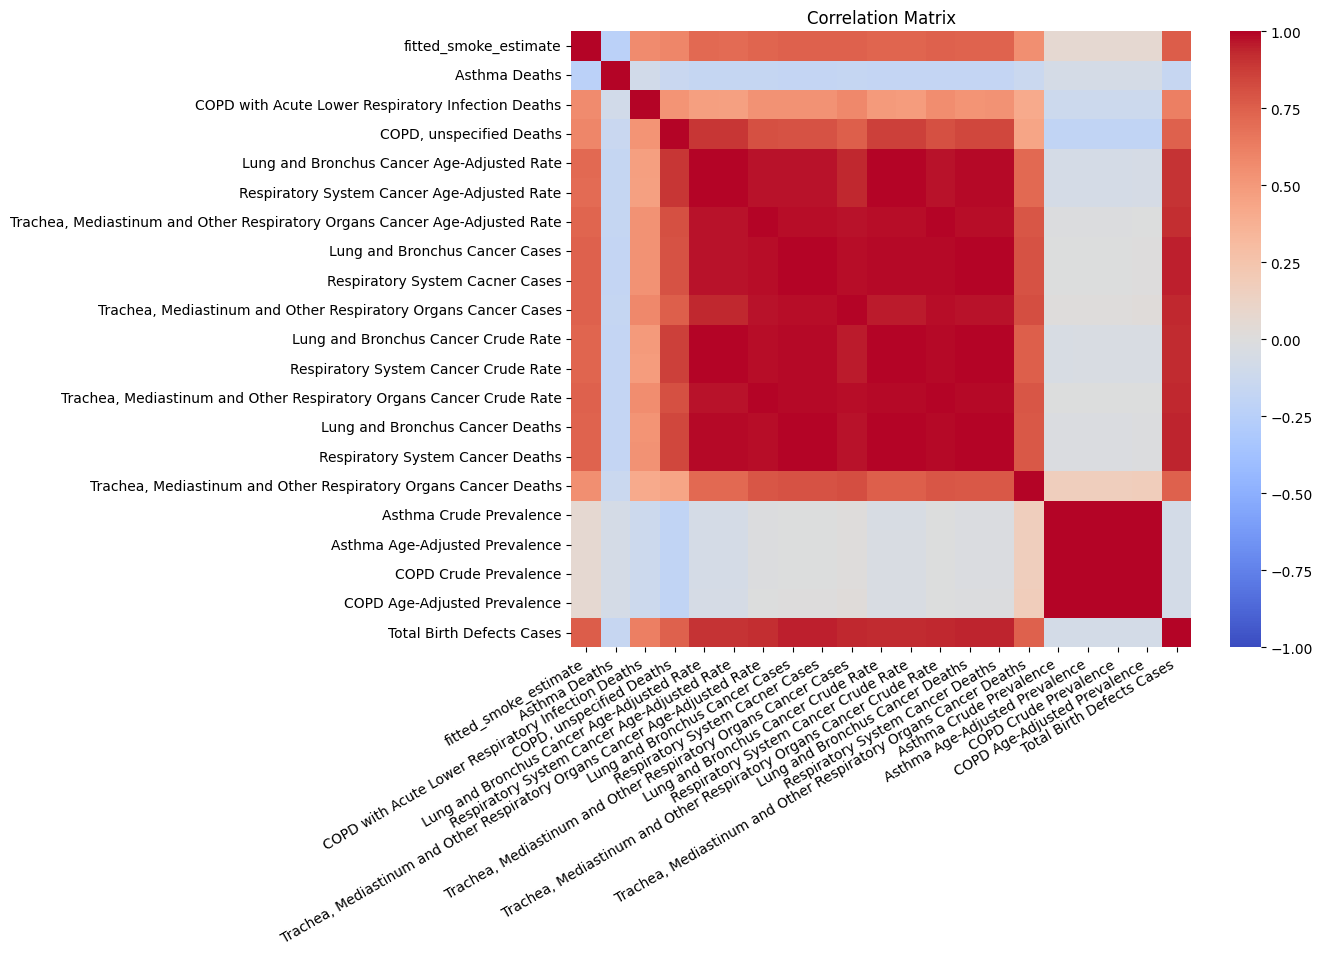

In [24]:
# corr matrix between each indicator
# corr_mat = merged_df.drop(columns=["fire_year"]).corr()
corr_mat = merged_df_fill_na_with_0.drop(columns=["fire_year"]).corr()

plt.figure(figsize=(10, 8))
h = sns.heatmap(corr_mat, annot=False, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
_ = h.set_xticklabels(h.get_xticklabels(), rotation=30, ha='right')
plt.title('Correlation Matrix')
plt.show()

Sort corr from highest to lowest

In [25]:
corr_mat.sort_values(by="fitted_smoke_estimate", ascending=False)[["fitted_smoke_estimate"]]

,fitted_smoke_estimate
fitted_smoke_estimate,1.000000
Total Birth Defects Cases,0.760138
"Trachea, Mediastinum and Other Respiratory Organs Cancer Cases",0.749486
"Trachea, Mediastinum and Other Respiratory Organs Cancer Crude Rate",0.749435
Lung and Bronchus Cancer Cases,0.746209
Respiratory System Cacner Cases,0.746142
Respiratory System Cancer Deaths,0.740349
Lung and Bronchus Cancer Deaths,0.740044
"Trachea, Mediastinum and Other Respiratory Organs Cancer Age-Adjusted Rate",0.731190
Lung and Bronchus Cancer Crude Rate,0.727568


Plot heatmap of smoke estimate to each health-related indicator

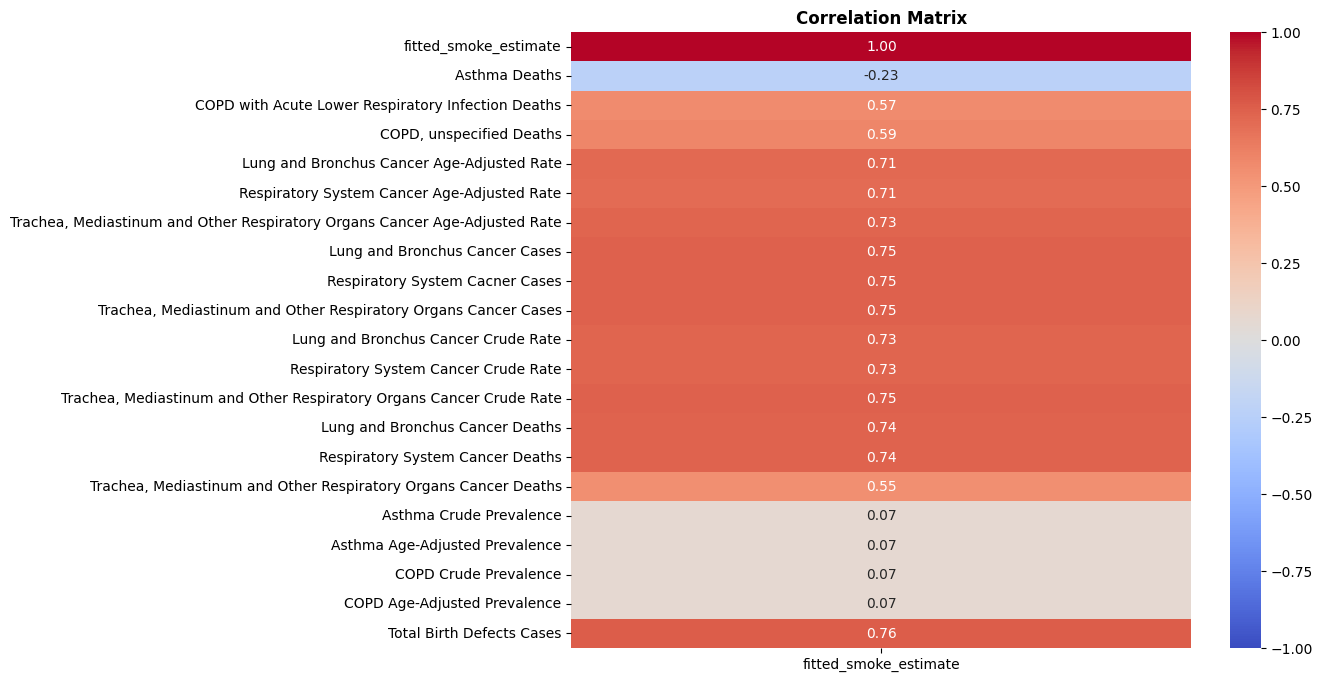

In [26]:
plt.figure(figsize=(10, 8))
h = sns.heatmap(corr_mat[['fitted_smoke_estimate']], annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
_ = h.set_xticklabels(h.get_xticklabels(), rotation=0, ha='center')
plt.title('Correlation Matrix', weight= 'bold')
plt.show()

## Forecast health-related indicators for 2025 - 2050
* Vector Autoregressive Moving Average with eXogenous regressors model (VARMAX): model dynamic relationships both among the dependent variables and between the dependent and independent variables
* We are using the VARMAX model because it allows us to capture the interdependencies between health indicators, recognizing that changes in one health metric (e.g., respiratory diseases) can directly or indirectly influence others (e.g., birth defect rates). Additionally, incorporating smoke density estimates as an exogenous variable enables us to account for its external influence on health outcomes, ensuring that our forecasts reflect both the intrinsic relationships among health indicators and the impact of environmental factors.
* We trained four models with each health indicator groups. They are grouped by how related they are with each other (ex. all related to asthma and copd or or age-adjusted rates on incidence)

In [27]:
merged_df_fill_na_with_0.columns

Index(['fire_year', 'fitted_smoke_estimate', 'Asthma Deaths',
       'COPD with Acute Lower Respiratory Infection Deaths',
       'COPD, unspecified Deaths',
       'Lung and Bronchus Cancer Age-Adjusted Rate',
       'Respiratory System Cancer Age-Adjusted Rate',
       'Trachea, Mediastinum and Other Respiratory Organs Cancer Age-Adjusted Rate',
       'Lung and Bronchus Cancer Cases', 'Respiratory System Cacner Cases',
       'Trachea, Mediastinum and Other Respiratory Organs Cancer Cases',
       'Lung and Bronchus Cancer Crude Rate',
       'Respiratory System Cancer Crude Rate',
       'Trachea, Mediastinum and Other Respiratory Organs Cancer Crude Rate',
       'Lung and Bronchus Cancer Deaths', 'Respiratory System Cancer Deaths',
       'Trachea, Mediastinum and Other Respiratory Organs Cancer Deaths',
       'Asthma Crude Prevalence', 'Asthma Age-Adjusted Prevalence',
       'COPD Crude Prevalence', 'COPD Age-Adjusted Prevalence',
       'Total Birth Defects Cases'],
      dty

Uses the `VARMAX` (Vector Autoregressive Moving-Average with Exogenous Regressors) model to forecast multiple health indicators (endogenous variables) for the years 2025–2050, based on historical smoke estimates (exogenous variable). 

#### Key Components:
1. **`endog_vars`**: A list of lists containing different groups of health indicators (e.g., asthma deaths, cancer rates, birth defects). These are the endogenous variables we aim to forecast.
2. **`exog`**: The exogenous variable (`fitted_smoke_estimate`) derived from historical wildfire smoke estimates, used as a indicator for the VARMAX model.
3. **Forecasting Loop**:
   - Iterates through each group of health indicators in `endog_vars`.
   - Fits a VARMAX model to historical data (up to 2024).
   - Uses the fitted model to forecast health indicators for 2025–2050, based on future smoke estimates (`future_exog`).

In [28]:
# define groups of health indicators (endogenous variables)
endog_vars = [
	['Asthma Deaths',
	'COPD with Acute Lower Respiratory Infection Deaths',
	'Asthma Crude Prevalence', 'COPD Crude Prevalence'],
	['Lung and Bronchus Cancer Age-Adjusted Rate',
	'Respiratory System Cancer Age-Adjusted Rate',
	'Trachea, Mediastinum and Other Respiratory Organs Cancer Age-Adjusted Rate'],
	['Lung and Bronchus Cancer Cases',
	'Respiratory System Cacner Cases',
	'Trachea, Mediastinum and Other Respiratory Organs Cancer Cases'],
	['Lung and Bronchus Cancer Deaths', 'Respiratory System Cancer Deaths',
	'Trachea, Mediastinum and Other Respiratory Organs Cancer Deaths',
	'Total Birth Defects Cases']
]

# exogenous variable (smoke estimate) with proper time index
exog = df_smoke_estime_before_2025[["fitted_smoke_estimate"]]
exog.index = pd.to_datetime(df_smoke_estime_before_2025["fire_year"], format="%Y")
df_forecast = pd.DataFrame()

for endo in endog_vars:
	# select and index the endogenous variables (health indicators)
	endog = merged_df_fill_na_with_0[endo]
	endog.index = pd.to_datetime(df_smoke_estime_before_2025["fire_year"], format="%Y")

	# fit VARMAX model using historical data up to 2024
	model = VARMAX(endog.loc[:"2024"], exog=exog.loc[:"2024"], order=(1, 1))
	model_fit = model.fit(disp=False)

	# forecast future values for fire_smoke_estimate (2025–2050) using VARMAX
	# replace this with the forecasted values you obtained earlier
	future_exog = df_smoke_estimate[df_smoke_estimate["fire_year"] >= 2025][["fitted_smoke_estimate"]]
	future_exog.index = pd.date_range(start="2025", end="2051", freq="Y")

	# forecast for 2025–2050
	forecast = model_fit.get_forecast(steps=26, exog=future_exog)
	forecast_mean = forecast.predicted_mean

	# append forecast results to the df
	if df_forecast.empty:
		df_forecast = forecast_mean
	else:
		df_forecast = pd.concat([df_forecast, forecast_mean], axis=1)
df_forecast.head()

,Asthma Deaths,COPD with Acute Lower Respiratory Infection Deaths,Asthma Crude Prevalence,COPD Crude Prevalence,Lung and Bronchus Cancer Age-Adjusted Rate,Respiratory System Cancer Age-Adjusted Rate,"Trachea, Mediastinum and Other Respiratory Organs Cancer Age-Adjusted Rate",Lung and Bronchus Cancer Cases,Respiratory System Cacner Cases,"Trachea, Mediastinum and Other Respiratory Organs Cancer Cases",Lung and Bronchus Cancer Deaths,Respiratory System Cancer Deaths,"Trachea, Mediastinum and Other Respiratory Organs Cancer Deaths",Total Birth Defects Cases
2025-01-01,0.068214,2.210538,8.187312,5.311610,5.233438,5.658013,0.025109,1637.306618,1774.635175,7.119616,762.994747,789.168053,-0.616651,3693.464376
2026-01-01,0.021538,2.881362,8.862688,5.789899,10.746940,11.595681,0.044254,2866.545222,3103.647392,11.422221,1858.709740,1925.137852,3.497471,7149.902489
2027-01-01,0.030677,3.545557,9.033835,5.897779,14.800875,15.956186,0.057601,3783.563261,4093.993336,14.665687,2598.892566,2691.693827,5.138900,9495.692927
2028-01-01,0.025693,4.047359,9.239748,6.032253,17.844586,19.229179,0.067652,4511.832836,4880.447135,17.413924,3112.941667,3223.521588,6.470555,11191.011683
2029-01-01,0.022624,4.438608,9.433766,6.158676,20.140180,21.697567,0.075330,5088.155286,5502.707071,19.669113,3498.879645,3622.426287,7.197596,12511.270247


Visualize forecasted results

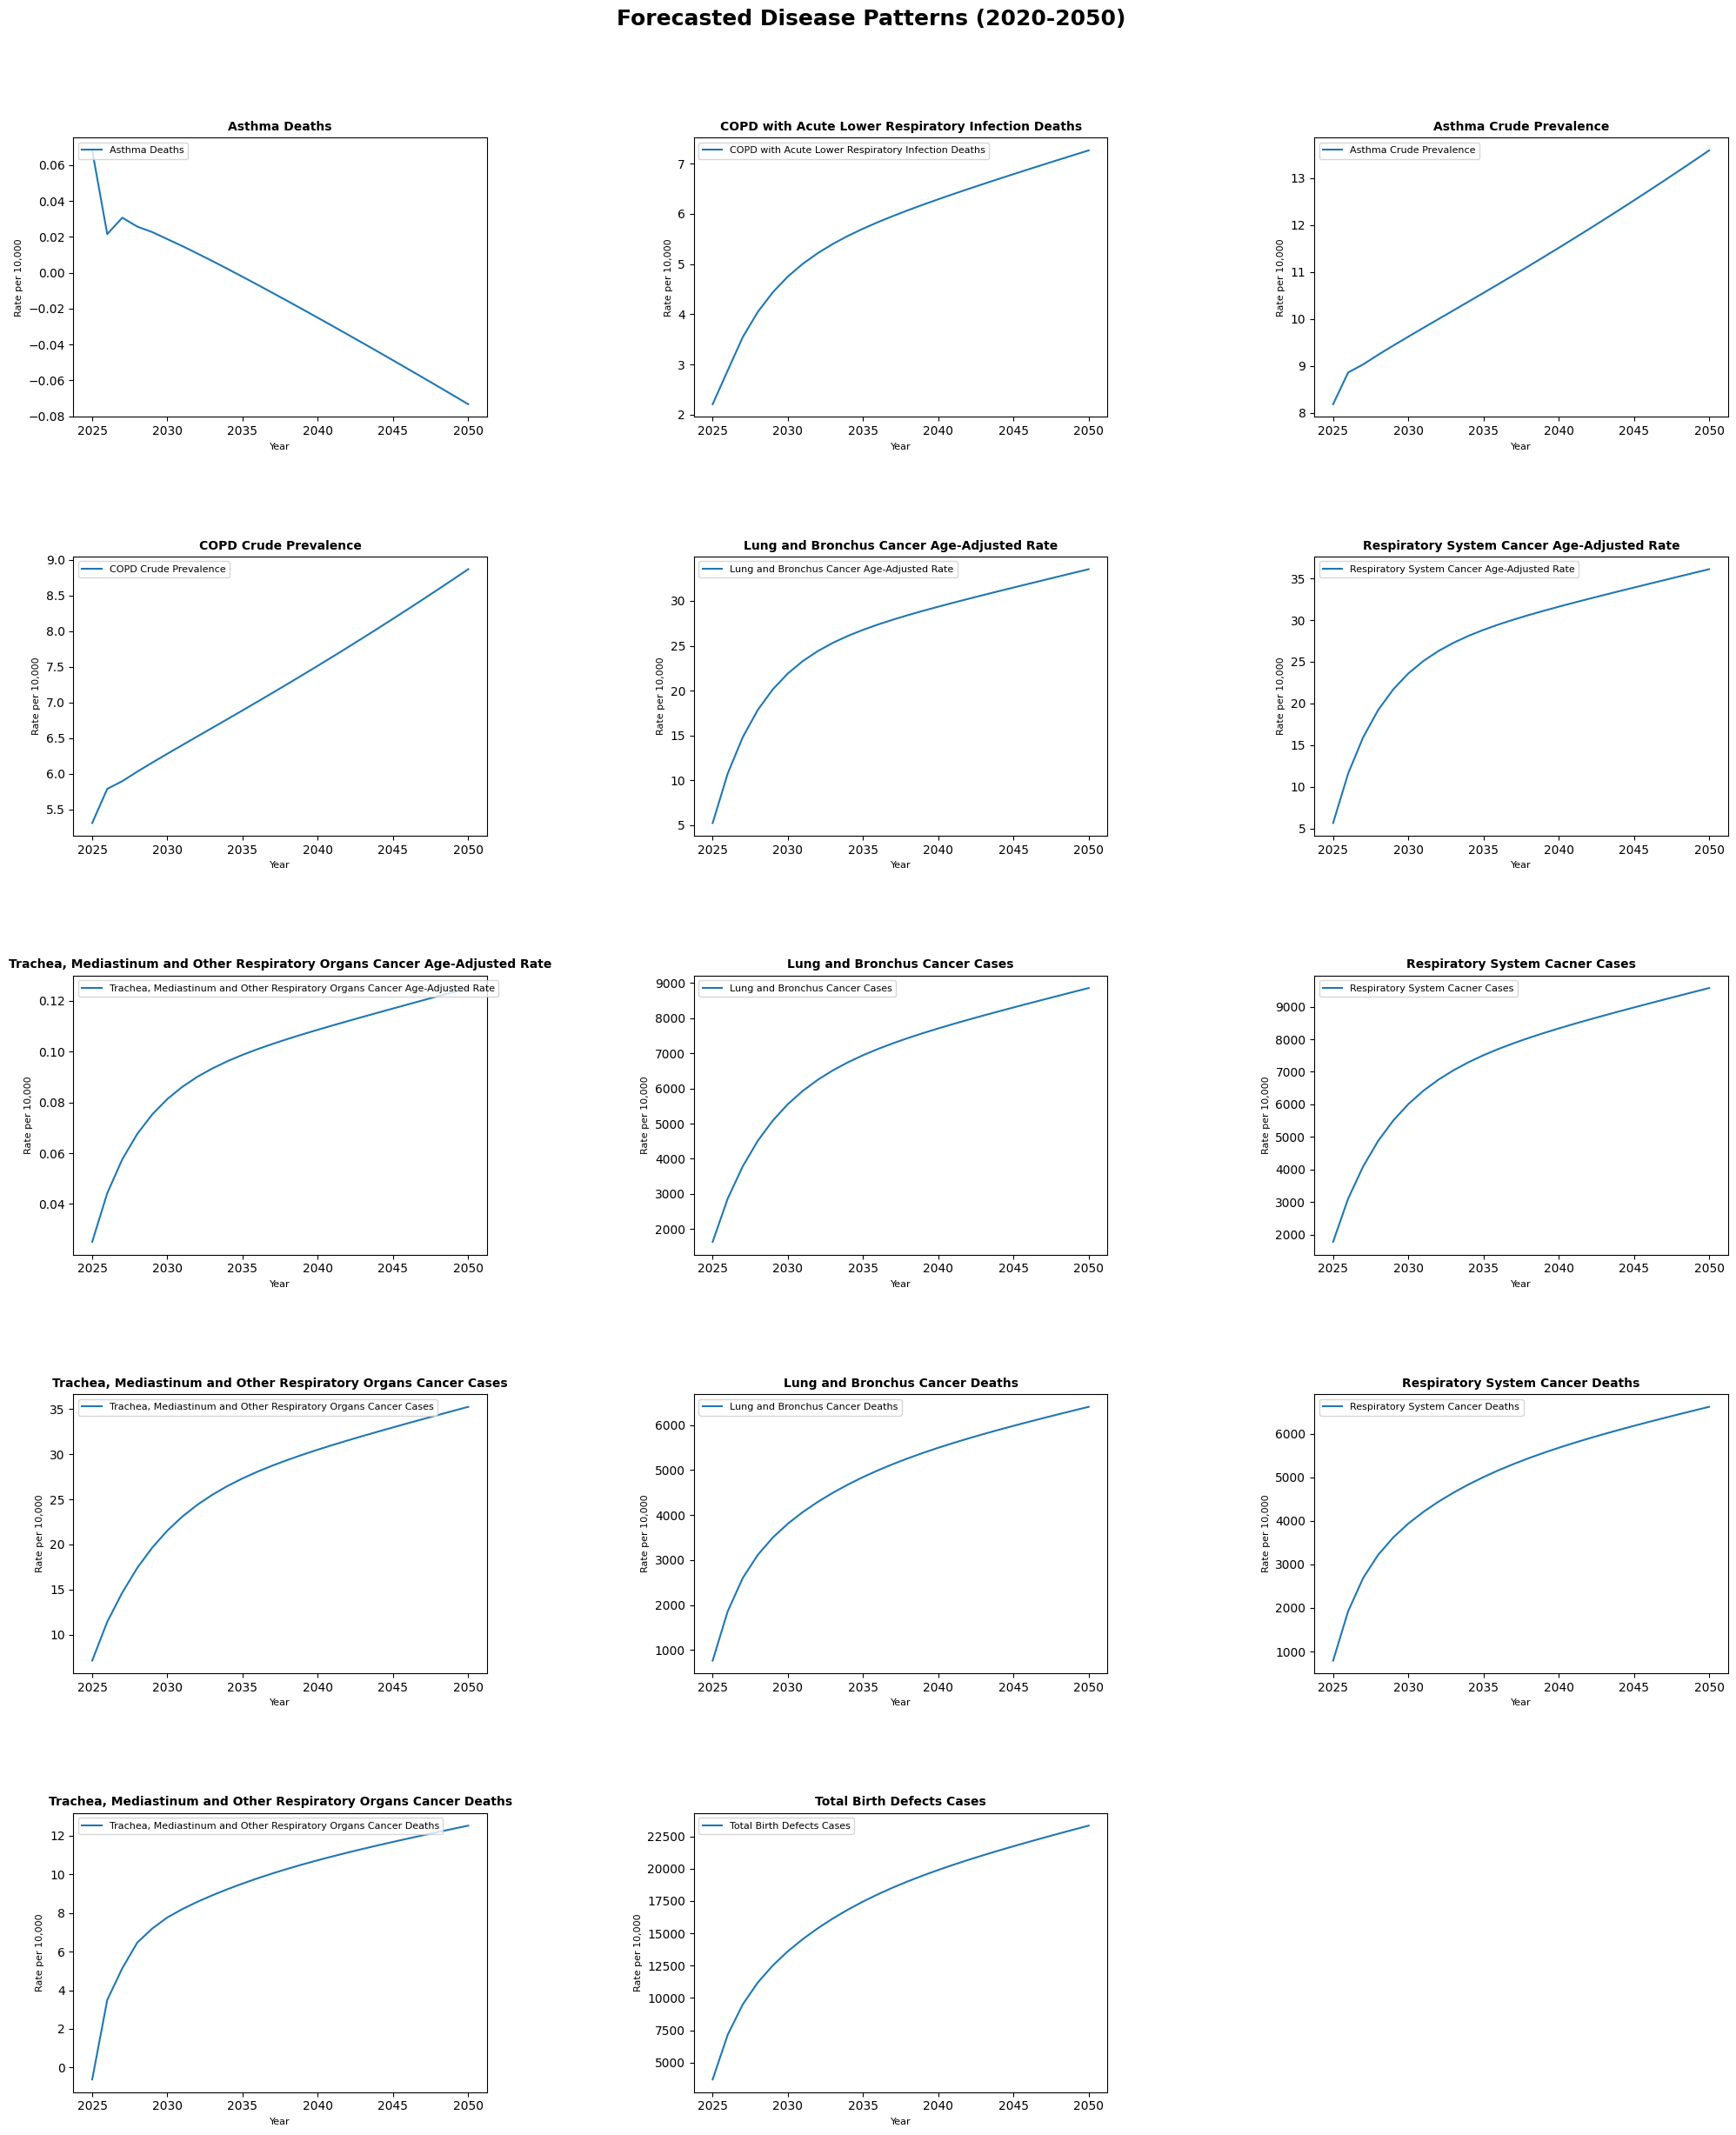

In [29]:
num_vars = len(df_forecast.columns)
num_rows = 5

# subplots with larger spacing
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(20, num_rows * 5))
axes = axes.flatten()  # flatten axes for easy iteration

for i, column in enumerate(df_forecast.columns):
    sns.lineplot(data=df_forecast, x=df_forecast.index.year, y=column, ax=axes[i], label=column)

    axes[i].set_title(column.replace("Chronic obstructive pulmonary disease", "COPD"), fontsize=10, weight='bold')
    axes[i].set_xlabel('Year', fontsize=8)
    axes[i].set_ylabel('Rate per 10,000', fontsize=8)
    axes[i].legend(loc="upper left", fontsize=8)

# hide unused subplots
for j in range(len(df_forecast.columns), len(axes)):
    fig.delaxes(axes[j])


plt.suptitle("Forecasted Disease Patterns (2020-2050)", fontsize=18, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.5, wspace=0.5)

plt.show()